In [1]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import AUC
from keras.optimizers import Adam

# Preprocessing

In [4]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [5]:
train.shape

(165034, 11)

In [6]:
X = train.drop(columns='Exited')
y = train.Exited

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.15)

In [8]:
prepro = Preprocessing()

In [9]:
X_train_scld = prepro.fit_transform(X_train).astype(float)
X_test_scld = prepro.transform(X_test).astype(float)

In [10]:
X_train_scld

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
id,,,,,,,,,,,,
159019,1.318584,1.0,1.0,-0.75,1.161653,-1.0,1.0,1.0,-0.551673,0.0,0.0,1.0
157972,-0.504425,0.0,-0.8,0.25,0.000000,0.0,1.0,0.0,0.766384,0.0,0.0,1.0
102593,0.486726,0.0,-0.1,1.00,0.943322,-1.0,1.0,0.0,-0.368541,0.0,1.0,0.0
125104,0.353982,0.0,-0.6,0.50,0.552585,0.0,1.0,0.0,0.204367,0.0,0.0,1.0
120124,-0.123894,0.0,1.0,-1.00,0.928026,-1.0,1.0,0.0,-0.333113,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3565,-0.778761,1.0,-0.4,1.00,0.000000,0.0,1.0,0.0,0.356574,1.0,0.0,0.0
27399,0.070796,1.0,-0.3,-1.25,0.866647,-1.0,1.0,0.0,-1.217734,0.0,1.0,0.0
112011,0.805310,1.0,-0.2,-1.00,0.000000,0.0,1.0,0.0,-0.878843,1.0,0.0,0.0


# Model

In [11]:
X_train_scld.shape

(140278, 12)

In [12]:
model = Sequential(name="BankChurn")
model.add(Dense(units=64, activation='relu', input_dim=12, name="Dense64"))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu', input_dim=12, name="Dense32"))
model.add(Dropout(0.1))
model.add(Dense(units=16, activation='relu', input_dim=12, name="Dense16"))
model.add(Dropout(0.1))


model.add(Dense(units=1, activation='sigmoid', name="Output"))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[AUC()])


2024-01-15 14:07:46.597826: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-01-15 14:07:46.597849: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-15 14:07:46.597857: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-15 14:07:46.597910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-15 14:07:46.597952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.summary()

Model: "BankChurn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense64 (Dense)             (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Dense32 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 Dense16 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 Output (Dense)              (None, 1)                 17

In [15]:
history = model.fit(X_train_scld.values, y_train.values, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
3507/3507 [==============================] - 44s 13ms/step - loss: 0.5185 - auc: 0.7424 - val_loss: 0.4196 - val_auc: 0.7953
Epoch 2/20
3507/3507 [==============================] - 42s 12ms/step - loss: 0.4887 - auc: 0.7555 - val_loss: 0.5180 - val_auc: 0.7922
Epoch 3/20
3507/3507 [==============================] - 43s 12ms/step - loss: 0.5822 - auc: 0.7268 - val_loss: 0.6448 - val_auc: 0.5526
Epoch 4/20
3507/3507 [==============================] - 44s 13ms/step - loss: 0.7544 - auc: 0.7008 - val_loss: 0.4865 - val_auc: 0.8056
Epoch 5/20
3507/3507 [==============================] - 44s 12ms/step - loss: 0.9613 - auc: 0.6861 - val_loss: 1.1693 - val_auc: 0.7950
Epoch 6/20
3507/3507 [==============================] - 53s 15ms/step - loss: 1.2526 - auc: 0.6773 - val_loss: 1.5342 - val_auc: 0.5526
Epoch 7/20
3507/3507 [==============================] - 53s 15ms/step - loss: 1.6343 - auc: 0.6705 - val_loss: 1.0897 - val_auc: 0.7102
Epoch 8/20
3507/3507 [==========================

In [16]:
pred = model.predict(X_test_scld.values)

774/774 [==============================] - 1s 2ms/step


In [17]:
pred[:,0]

array([6.7120031e-02, 1.0000000e+00, 9.9999702e-01, ..., 1.0441639e-06,
       2.2651902e-01, 6.2406976e-03], dtype=float32)

# Score

In [18]:
RocScore  = roc_auc_score(y_test, pred[:,0])
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.662783


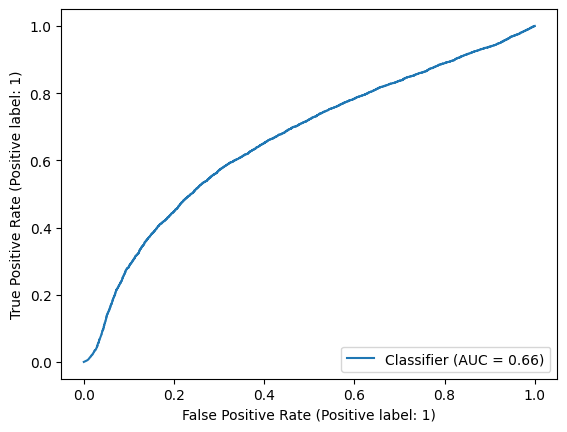

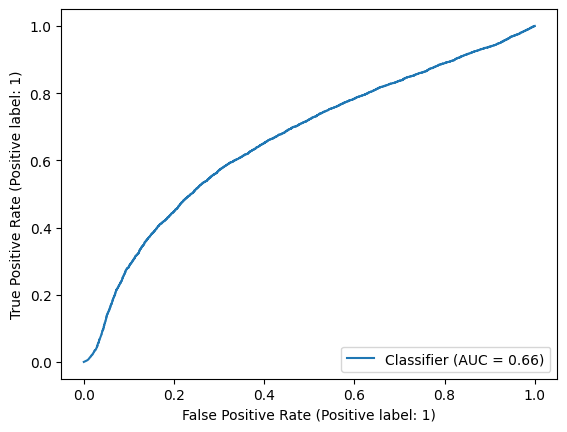

In [19]:
RocCurveDisplay.from_predictions(y_test,pred).plot()

# Submission

In [ ]:
X_val_scld = prepro.transform(test)

In [ ]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [ ]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
submission

,Exited
id,
165034,0.085936
165035,0.947197
165036,0.079534
165037,0.519489
165038,0.638603
...,...
275052,0.132850
275053,0.217605
275054,0.071276


In [ ]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [ ]:
#submission.to_csv(f"submission/{name}.csv")